In [16]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import os as os

In [1]:
participantID = 'pb_04'
condition_og  = 'base1'
condition_new = 'base_ground'
csvFolder     = 'C:/Users/seinj/Teaching/Recordings_2023_EMG-ECG/csv-data/'
resultsFolder = 'C:/Users/seinj/Teaching/EMG-ECG analysis/'

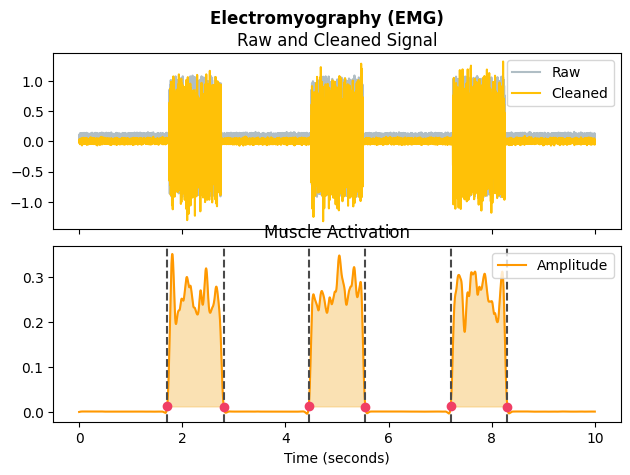

In [4]:
# Simulated EMG data : process and visualize 
emg = nk.emg_simulate(duration=10, sampling_rate=1000, burst_number=3)
signals, info = nk.emg_process(emg, sampling_rate=1000)
nk.emg_plot(signals, info)

In [9]:
# Recorded EDA data : process and visualize 
# csv_file_path = 'C:/Users/seinj/Teaching/Recordings_2023_EMG-ECG/csv-data/pb_04_elevated_emg.csv'
csv_file_path = csvFolder + participantID + '_' + condition_og + '_emg.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, header=None, names=['Column1'], skiprows=1)

# Extract the single column as a vector
emg_data = df['Column1'].values
print(emg_data[:10])

[-0.003  0.    -0.003 -0.003 -0.003  0.    -0.006 -0.003 -0.01  -0.01 ]


In [10]:
# process a small time window
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_process.html#emg_process
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_activation.html#emg_activation
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_amplitude.html#emg_amplitude
# https://neuropsychology.github.io/NeuroKit/examples/bio_custom/bio_custom.html
signals_cropped, info = nk.emg_process(emg_data[50000:57000], sampling_rate=1000)
display(signals_cropped)

C:\Users\seinj\AppData\Local\Programs\Python\Python312\Lib\site-packages\neurokit2\events\events_find.py:118: NeuroKitWarning: No events found. Check your event_channel or adjust 'threshold' or 'keep' arguments.
  warn(


,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity,EMG_Onsets,EMG_Offsets
0,-0.003,-0.000013,0.000006,0.0,0,0
1,-0.003,0.000387,0.000006,0.0,0,0
2,-0.006,-0.002241,0.000006,0.0,0,0
3,-0.003,0.001085,0.000006,0.0,0,0
4,-0.006,-0.001650,0.000007,0.0,0,0
...,...,...,...,...,...,...
6995,0.000,0.001300,0.000021,0.0,0,0
6996,0.003,0.004268,0.000021,0.0,0,0
6997,0.006,0.008060,0.000021,0.0,0,0
6998,0.000,0.003746,0.000021,0.0,0,0


In [7]:
# plot results
nk.emg_plot(signals_cropped, info)

# modify properties of the graphics object
fig = plt.gcf() 
plt.ylim(-0.001,0.005)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

NameError: name 'signals_cropped' is not defined

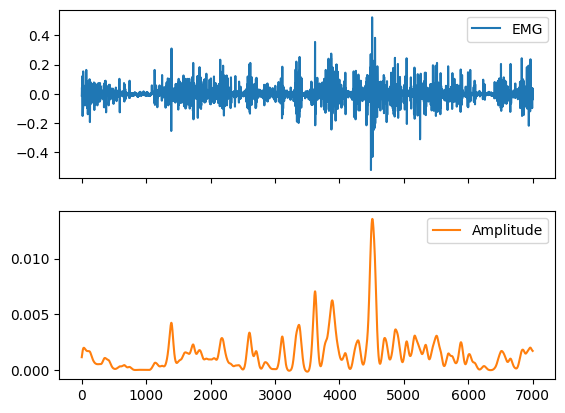

In [9]:
# try it out step by step
cleaned = nk.emg_clean(emg_data[50000:57000], sampling_rate=1000)
amplitude = nk.emg_amplitude(cleaned)
fig = pd.DataFrame({"EMG": emg_data[50000:57000], "Amplitude": amplitude}).plot(subplots=True)

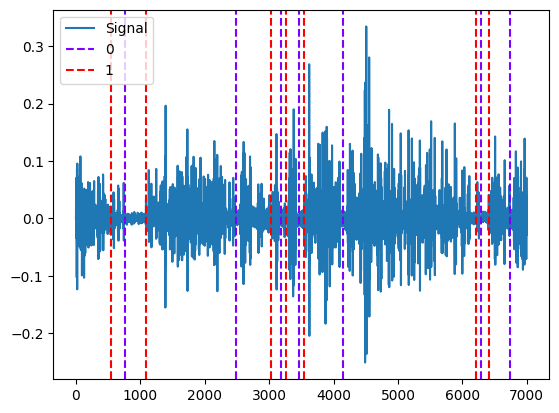

In [11]:
# method "threshold"
activity, info = nk.emg_activation(emg_amplitude=amplitude, method="threshold")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

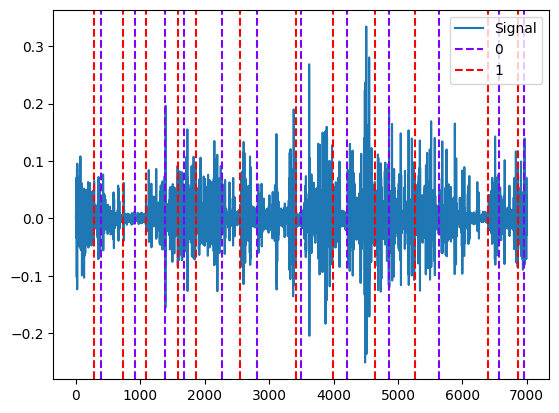

In [12]:
# method "pelt"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="pelt")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

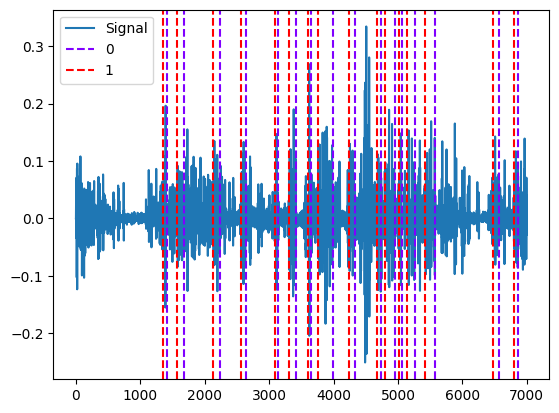

In [13]:
# method "Biosspy"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="biosppy")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

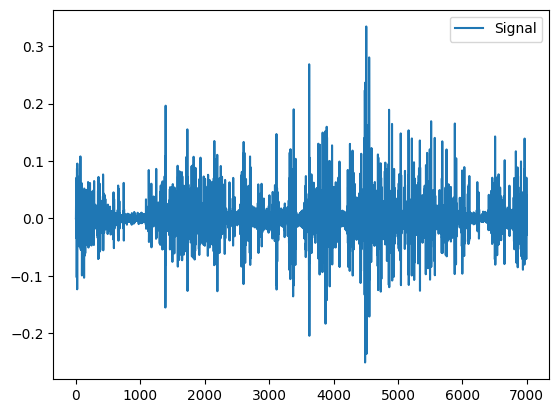

In [16]:
# method "silva"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="silva")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

In [11]:
# process the entire session
signals_full_length, info = nk.emg_process(emg_data, sampling_rate=1000)

In [14]:
# summarize the number of activation and mean amplitude for the given interval
analyze_df = nk.emg_analyze(signals_full_length, method="interval-related")
display(analyze_df)
results = analyze_df

,EMG_Activation_N,EMG_Amplitude_Mean
0,180.0,0.000074


In [17]:
# Save data into a table 

# Add a participant ID column to the DataFrame
results['Participant_ID'] = participantID

# Reorder columns so that the participant ID is the first column
results = results[['Participant_ID'] + [col for col in results.columns if col != 'Participant_ID']]

# Specify the file path for the TSV file
file_path = resultsFolder + 'results_' + condition_new + '_emg.tsv'

# Check if the file already exists
if os.path.exists(file_path):
    # If the file exists, read the existing data
    existing_data = pd.read_csv(file_path, sep='\t')

    # Iterate through participant IDs in the existing data
    for idx, row in results.iterrows():
        existing_index = existing_data.index[existing_data['Participant_ID'] == row['Participant_ID']]
        if not existing_index.empty:
            # If the participant ID already exists, drop the existing row and append the new row
            existing_data = pd.concat([existing_data.drop(existing_index), pd.DataFrame([row], columns=existing_data.columns)], ignore_index=True)
        else:
            # If the participant ID does not exist, append the row
            existing_data = pd.concat([existing_data, pd.DataFrame([row], columns=existing_data.columns)], ignore_index=True)

    # Save the updated DataFrame to the TSV file
    existing_data.to_csv(file_path, sep='\t', index=False)
else:
    # If the file does not exist, save the entire DataFrame to the TSV file
    results.to_csv(file_path, sep='\t', index=False)
